In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os
import warnings
import squarify # Treemaps
warnings.filterwarnings('ignore')
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

**Mean Shift Clustering** is an iterative algorithm that seeks modes or high-density regions in the data distribution.<br> It works by initializing a set of data points as cluster centers and iteratively shifting them towards the direction of higher density. The shifting process continues until convergence, where the cluster centers stabilize.<br> Mean Shift clustering does not require the number of clusters as an input parameter and can automatically determine the optimal number of clusters based on the data distribution.

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.rename(columns = {'Annual Income (k$)': "Income", 'Spending Score (1-100)': 'SpendScore'}, inplace = True)
X = df.drop(columns = ['CustomerID', 'Gender'], axis = 1)
X.columns

Index(['Age', 'Income', 'SpendScore'], dtype='object')

In [4]:
bandwidth = estimate_bandwidth(X, quantile = 0.1)
ms = MeanShift(bandwidth = bandwidth).fit(X)
X['Labels'] = ms.labels_
X.head()

,Age,Income,SpendScore,Labels
0,19,15,39,4
1,21,15,81,3
2,20,16,6,4
3,23,16,77,3
4,31,17,40,4


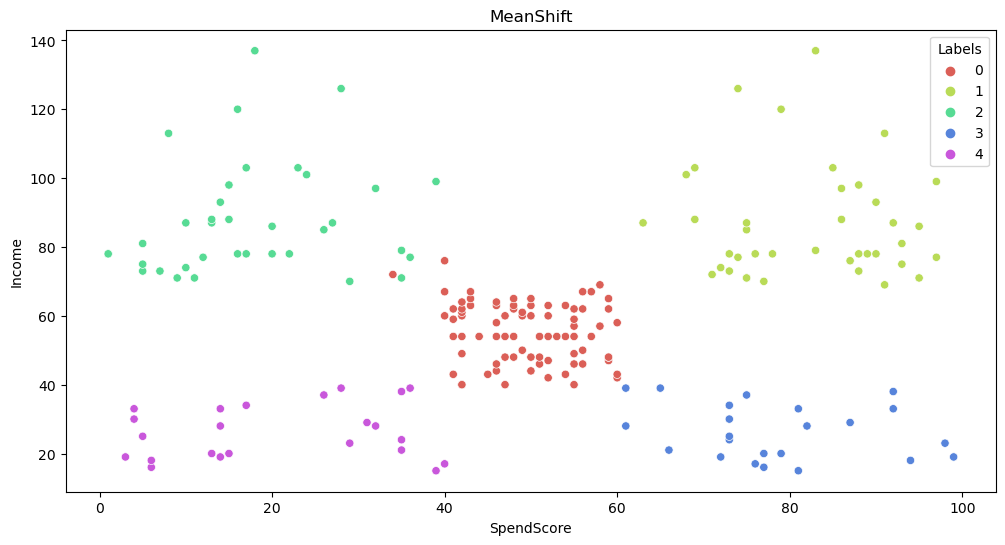

In [5]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x = X['SpendScore'], y = X['Income'], hue=X['Labels'], palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
plt.plot()
plt.title('MeanShift')
plt.show()

------

**Affinity Propagation** is a clustering algorithm that seeks to find exemplars, or representative data points, from a given dataset. It is a relatively recent clustering technique that does not require the number of clusters as an input parameter. Instead, it automatically determines both the number of clusters and the exemplars within the dataset.
The algorithm aims to find a set of exemplars that optimizes a measure of similarity known as "responsibility" and "availability."<br>

- **Responsibility**: Measures the accumulated evidence for how well-suited a point is to serve as an exemplar, considering the contributions of other points to its candidacy.

- **Availability**: Measures the accumulated evidence for the appropriateness of a point to choose another point as its exemplar, considering the availability of other points to be chosen as exemplars.

Affinity Propagation is particularly useful in scenarios where the number of clusters is unknown or when dealing with high-dimensional data. It can discover clusters of arbitrary shape and handle noisy data effectively. However, it can be computationally intensive and may not scale well for large datasets.

In [6]:
df = pd.read_csv('Mall_Customers.csv')
X_numerics = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
no_of_clusters = []
preferences = range(-20000, -5000, 100)  # arbitrarily chosen range
af_sil_score = []  # silhouette scores

for p in preferences:
    try:
        AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
        unique_labels = np.unique(AF.labels_)
        if len(unique_labels) > 1:
            no_of_clusters.append(len(unique_labels))
            af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
        else:
            no_of_clusters.append(0)
            af_sil_score.append(-1)
    except Exception as e:
        print(f"An error occurred for preference={p}: {str(e)}")
        no_of_clusters.append(0)
        af_sil_score.append(-1)

af_results = pd.DataFrame(
    [preferences, no_of_clusters, af_sil_score],
    index=['preference', 'clusters', 'sil_score']
).T
af_results = af_results[af_results['clusters'] > 1]  # Filter out results with only one cluster
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
37,-16300.0,6.0,0.451440
65,-13500.0,6.0,0.451440


In [7]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


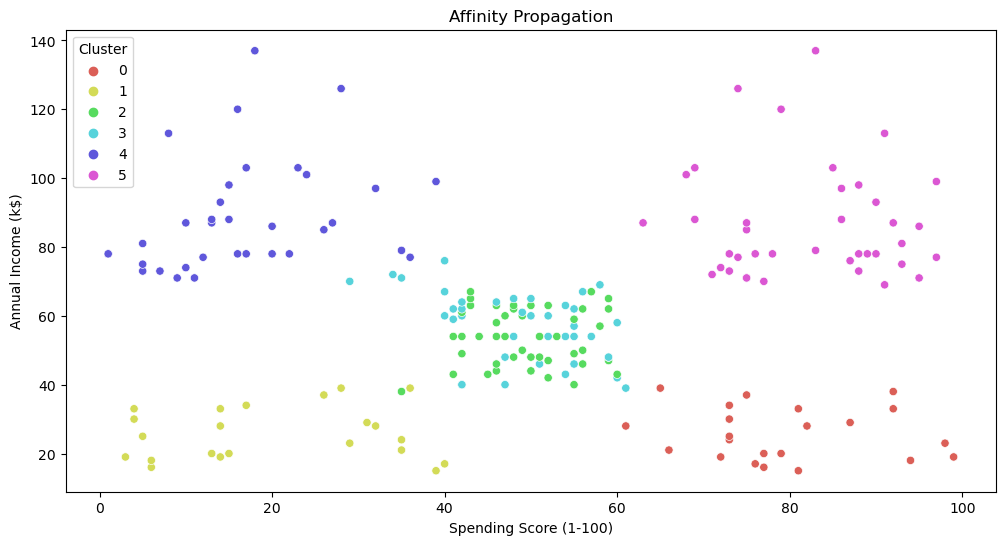

In [8]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x = AF_clustered['Spending Score (1-100)'], y = AF_clustered['Annual Income (k$)'], hue=AF_clustered['Cluster'], palette=sns.color_palette('hls', np.unique(AF.labels_).shape[0]))
plt.plot()
plt.title('Affinity Propagation')
plt.show()

---

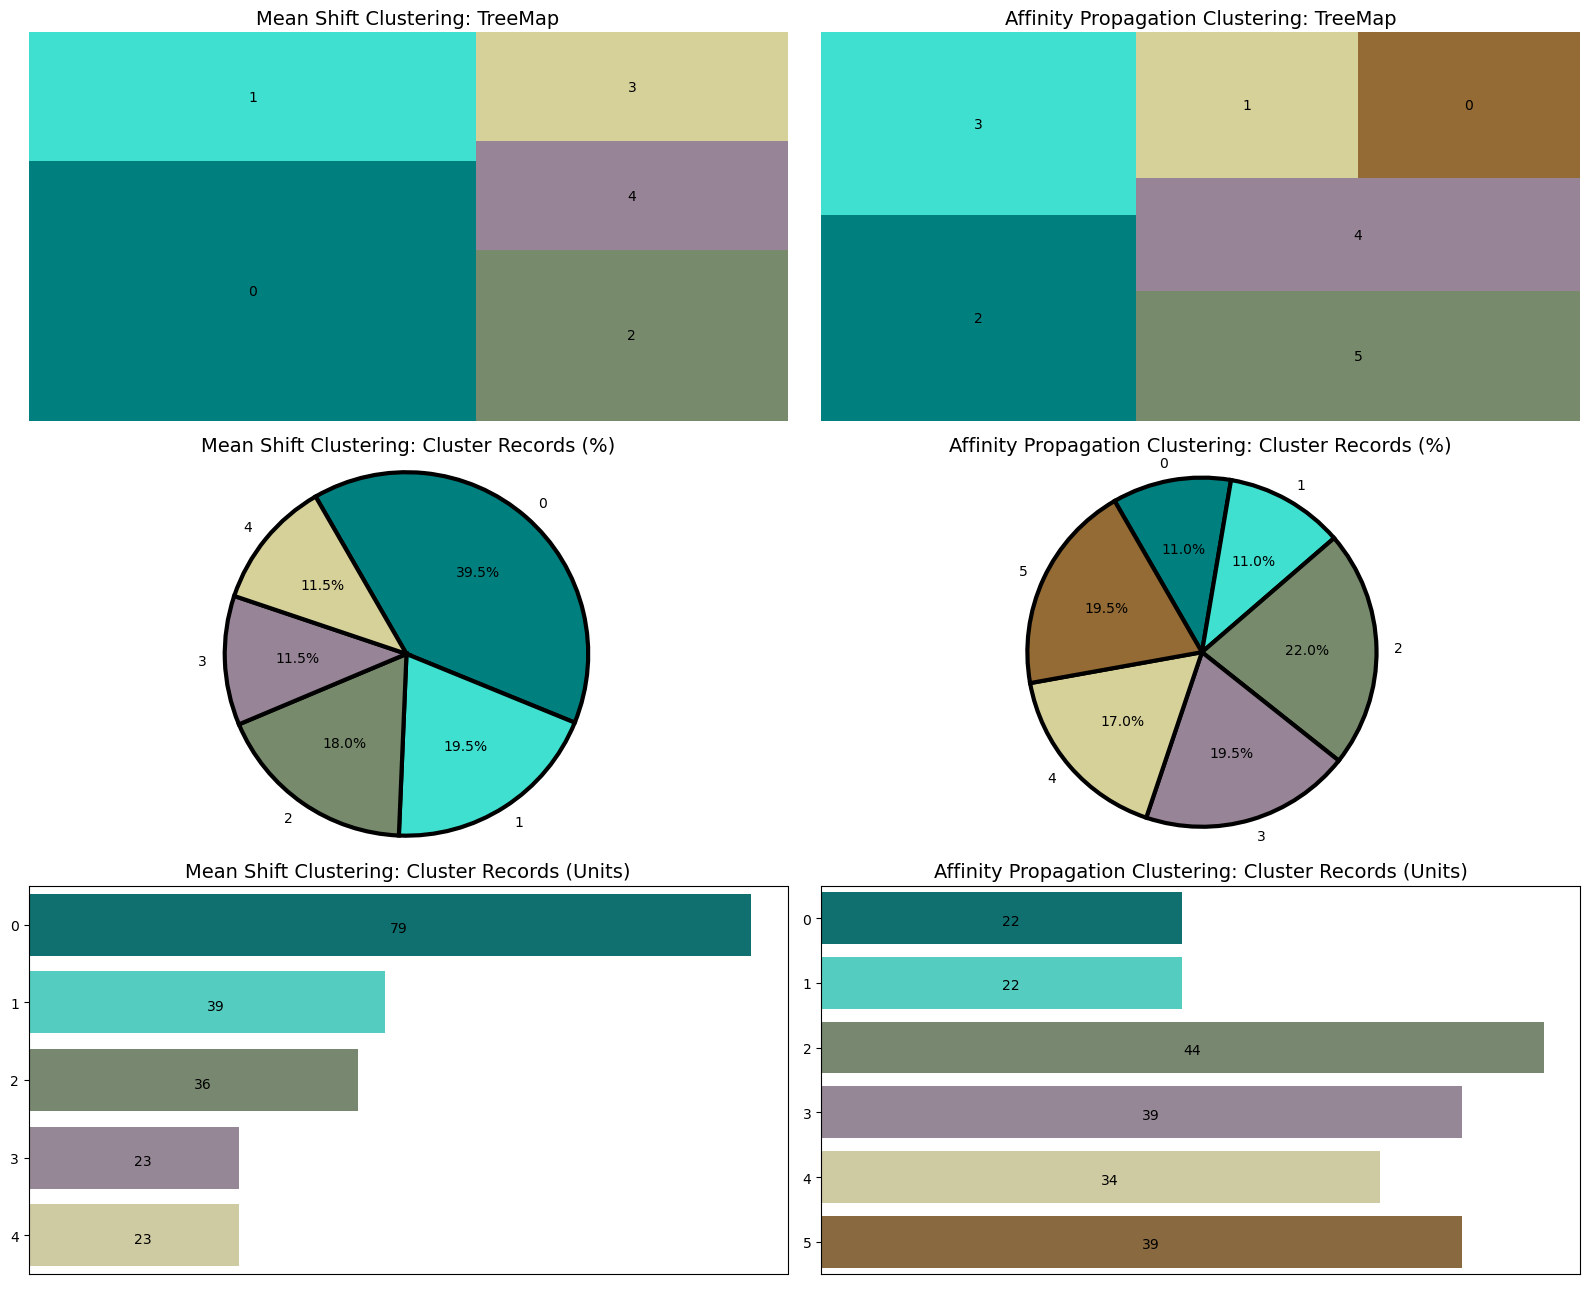

In [13]:
plt.subplots(figsize=(16,13))
my_pal = ('#007f7f','#40E0D0', '#778b6c', '#978597', '#d6d099')
pal = ('#007f7f','#40E0D0', '#778b6c', '#978597', '#d6d099', '#946b34')

plt.subplot(3, 2, 1)
plt.title('Mean Shift Clustering: TreeMap', fontsize = 14)
labels = X['Labels'].value_counts().index.get_level_values(0).tolist()
sizes = X['Labels'].value_counts().reset_index().Labels.values.tolist()
squarify.plot(sizes = sizes, label = labels, color = my_pal)
plt.axis('off')

plt.subplot(3, 2, 2)
plt.title('Affinity Propagation Clustering: TreeMap', fontsize = 14)
labels = AF_clustered['Cluster'].value_counts().index.get_level_values(0).tolist()
sizes = AF_clustered['Cluster'].value_counts().reset_index().Cluster.values.tolist()
squarify.plot(sizes = sizes, label = labels, color = pal)
plt.axis('off')

plt.subplot(3, 2, 3)
plt.title('Mean Shift Clustering: Cluster Records (%)', fontsize = 14)
sizes = X['Labels'].value_counts().sort_index() / (X['Labels'].value_counts().sum()*100)
labels = sizes.index
plt.pie(sizes, labels = labels, colors=my_pal, counterclock=False, startangle = 120, wedgeprops={'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(3, 2, 4)
plt.title('Affinity Propagation Clustering: Cluster Records (%)', fontsize = 14)
sizes = AF_clustered['Cluster'].value_counts().sort_index() / (AF_clustered['Cluster'].value_counts().sum()*100)
labels = sizes.index
plt.pie(sizes, labels = labels, colors=pal, counterclock=False, startangle = 120, wedgeprops={'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(3, 2, 5)
plt.title("Mean Shift Clustering: Cluster Records (Units)", fontsize = 14)
order = [0,1,2,3,4]
ax = sns.countplot(y = 'Labels', data = X, palette = my_pal, order = order)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()),  ((p.get_x() + p.get_width() + 0.05)/2, p.get_y()+0.5))
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.tight_layout()

plt.subplot(3, 2, 6)
plt.title("Affinity Propagation Clustering: Cluster Records (Units)", fontsize = 14)
order = [0,1,2,3,4,5]
ax = sns.countplot(y = 'Cluster', data = AF_clustered, palette = pal, order = order)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()),  ((p.get_x() + p.get_width() + 0.05)/2, p.get_y()+0.5))
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.tight_layout()

plt.show()